In [1]:
import numpy as np
from scipy import stats

np.random.seed(2020)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.xmargin'] = 0.05
mpl.rcParams['axes.ymargin'] = 0.05
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'

In [3]:
from utils.data import cov2d, gaussian_mixture
from utils import simplex

# Data

In [4]:
dim_features = 2
num_classes = 3
num_points = 600

# [num_classes]
p_z = np.array([.4, .3, .3])
# [num_classes, dim_features]
mean = np.array([[1.5, 0.0],
                 [-2.0, 1.0],
                 [-1.0, -2.0]])
# [num_classes, dim_features]
std = np.array([[1, 1],
                [1, 1],
                [1, 1]])
# [num_classes]
corr = np.array([0, .5, -.3])
# [num_classes, dim_features, dim_features]
cov = cov2d(std, corr)

In [5]:
x, z = gaussian_mixture(mean, cov, n=num_points, p=p_z)

In [6]:
# [num_points, num_classes]
p_x_z = np.stack([stats.multivariate_normal(mean[i], cov[i]).pdf(x) for i in range(num_classes)], -1)
# [num_points, num_classes]
p_xz = p_x_z * p_z
# [num_points]
p_x = p_xz.sum(1)
# [num_points, num_classes]
p_z_x = p_xz / p_x[:, None]

In [7]:
U = np.array([
    [.70, .25, .05],
    [.15, .60, .25],
    [.05, .15, .80],
])
V = np.array([
    [.90, .05, .05],
    [.15, .80, .05],
    [.00, .10, .90],
])
T = U @ V

In [8]:
# [num_points]
y = np.array([np.random.choice(num_classes, p=T[zi]) for zi in z])

In [9]:
p_y_x = p_z_x @ T

# Training

In [10]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(2020);

In [11]:
x_tensor = torch.tensor(x).float()
z_tensor = torch.tensor(z).long()
y_tensor = torch.tensor(y).long()

dataset_z = TensorDataset(x_tensor, z_tensor)
dataset_y = TensorDataset(x_tensor, y_tensor)

loader_z = DataLoader(dataset_z, batch_size=64, shuffle=True)
loader_y = DataLoader(dataset_y, batch_size=64, shuffle=True)

In [12]:
def get_model():
    return nn.Sequential(
        nn.Linear(dim_features, 32),
        nn.ReLU(inplace=True),
        nn.Linear(32, 32),
        nn.ReLU(inplace=True),
        nn.Linear(32, num_classes),
    )

In [13]:
def train(model, optimizer, loader, epochs=30):
    for epoch in range(epochs):
        for x_batch, z_batch in loader:
            loss = F.cross_entropy(model(x_batch), z_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [14]:
model = get_model()
optimizer = optim.Adam(model.parameters())
train(model, optimizer, loader_z)
with torch.no_grad():
    p_z_x_ = torch.softmax(model(x_tensor), 1).numpy()
z_ = p_z_x_.argmax(1)

In [15]:
model = get_model()
optimizer = optim.Adam(model.parameters())
train(model, optimizer, loader_y)
with torch.no_grad():
    p_y_x_ = torch.softmax(model(x_tensor), 1).numpy()
y_ = p_y_x_.argmax(1)

# Plot

In [16]:
c_z = simplex.Tc[z]
c_y = simplex.Tc[y]

In [17]:
x_range = [0, np.log(3)]

def hist(ax, h, **kwargs):
    ax.set_xlim(*x_range)
    default = dict(density=True, log=True, color=simplex.Tc)
    ax.hist(h, bins=np.linspace(*x_range, 20), **{**default, **kwargs})

def scatter(ax, x, z, c):
    for cls, marker in enumerate('ovs'):
        ax.scatter(*x[z == cls].T, color=c[z == cls], marker=marker)

def simplex_scatter(ax, p, z, c):
    for cls, marker in enumerate('ovs'):
        simplex.scatter(ax, p[z == cls], color=c[z == cls], marker=marker)
    
def entropy(p):
    return -(p * np.log(p)).sum(1)

def estimate_transition_matrix(p, q=1):
    threshold = np.quantile(p, q, axis=0, interpolation='higher')
    return p[np.where(p > threshold, 0, p).argmax(axis=0)]

In [18]:
T_ = estimate_transition_matrix(p_y_x_)

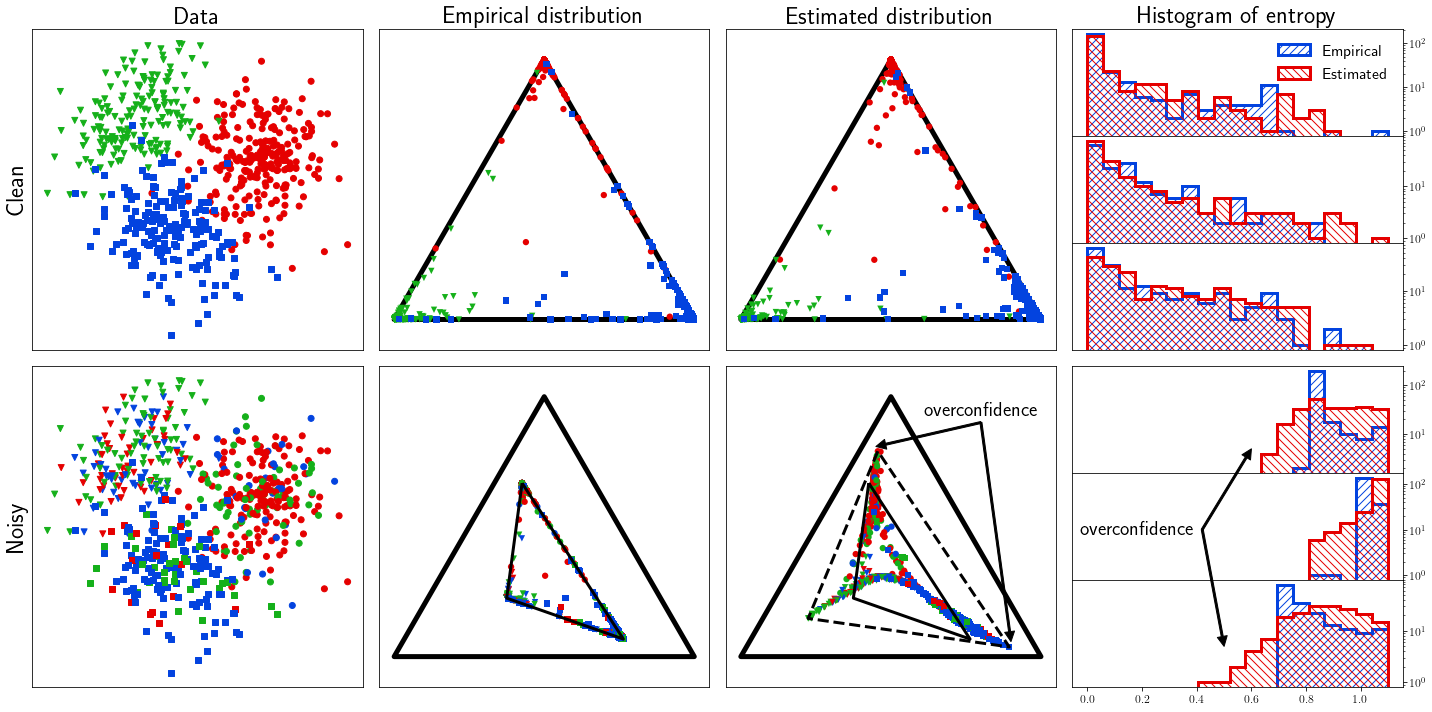

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
gs = axes[0][0].get_gridspec()

# data
for i, c in zip(range(2), [c_z, c_y]):
    ax = axes[i][0]
    ax.set_xticks([])
    ax.set_yticks([])
    scatter(ax, x, z, c)

# empirical
for i, p, c in zip(range(2), [p_z_x, p_y_x], [c_z, c_y]):
    ax = axes[i][1]
    simplex.init(ax)
    simplex.boundary(ax, zorder=0)
    simplex_scatter(ax, p, z, c)
    ax.axis('equal')
simplex.lines(ax, [np.concatenate((T, T[:1])) @ simplex.Ts], 
              linewidth=3, linestyle='solid')

# estimated
for i, p, c in zip(range(2), [p_z_x_, p_y_x_], [c_z, c_y]):
    ax = axes[i][2]
    simplex.init(ax)
    simplex.boundary(ax, zorder=0)
    simplex_scatter(ax, p, z, c)
    ax.axis('equal')
simplex.lines(ax, [np.concatenate((T, T[:1])) @ simplex.Ts], 
              linewidth=3, linestyle='solid')
simplex.lines(ax, [np.concatenate((T_, T_[:1])) @ simplex.Ts], 
              linewidth=3, linestyle='dashed')

# entropy
sub_axes = []
for i, p, q in zip(range(2), [p_z_x, p_y_x], [p_z_x_, p_y_x_]):
    axes[i][3].remove()
    sub_gs = gs[i, -1].subgridspec(nrows=3, ncols=1, wspace=0, hspace=0)
    sub_axes.append(sub_gs.subplots())
    for j in range(3):
        ax = sub_axes[i][j]
        ax.yaxis.tick_right()
        hist_params = dict(bins=np.linspace(*x_range, 20), log=True, 
                           histtype='step', linewidth=3)
        ax.hist(entropy(p[z == j]), label='Empirical', 
                color='xkcd:blue', hatch='/' * 3, **hist_params)
        ax.hist(entropy(q[z_ == j]), label='Estimated', 
                color='xkcd:red', hatch='\\' * 3, **hist_params)
sub_axes[0][0].legend(loc='upper right')
sub_axes[0][2].set_xticks([])

# labels
axes[0][0].set_ylabel('Clean')
axes[1][0].set_ylabel('Noisy')

axes[0][0].set_title('Data')
axes[0][1].set_title('Empirical distribution')
axes[0][2].set_title('Estimated distribution')
sub_axes[0][0].set_title('Histogram of entropy')

# annotations
text_params = dict(fontsize=20, ha='center', va='center')
arrowstyle = mpl.patches.ArrowStyle('simple', head_length=1, head_width=1)
arrow_params = dict(coordsA='data', coordsB='data',
                    facecolor='k', linewidth=1, arrowstyle=arrowstyle)

ax = axes[1][2]
ax.text(0.8, 0.82, 'overconfidence', **text_params)
ax.add_artist(mpl.patches.ConnectionPatch(
    xyA=(0.8, 0.78), xyB=(0.45, 0.7), axesA=ax, **arrow_params))
ax.add_artist(mpl.patches.ConnectionPatch(
    xyA=(0.8, 0.78), xyB=(0.9, 0.05), axesA=ax, **arrow_params))

sub_axes[1][1].text(0.18, 10, 'overconfidence', **text_params)
sub_axes[1][1].add_artist(mpl.patches.ConnectionPatch(
    xyA=(0.42, 10), xyB=(0.6, 5), 
    axesA=sub_axes[1][1], axesB=sub_axes[1][0], **arrow_params))
sub_axes[1][2].add_artist(mpl.patches.ConnectionPatch(
    xyA=(0.42, 10), xyB=(0.5, 5), 
    axesA=sub_axes[1][1], axesB=sub_axes[1][2], **arrow_params))

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)